# Проект: сборный проект №1

# Анализ данных и проверка гипотез данных покупателей интернет-магазина «Стримчик»

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо их проанализировать и проверить некоторые гипотезы, которые позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


**Цель исследования:**
1. Выявить актуальный период, который поможет построить прогноз на 2017 год.
2. Рассмотреть продажи игр в зависимости от платформы, отзывов, жанров.
3. Составить портрет пользователя каждого региона.
4. Проверить гипотезы о средних пользовательский рейтингах в разных категориях.

**Ход исследования**

Данные получим из файла `/datasets/games.csv` , просмотрим общую информацию о датасете, оценим качество данных.

Далее приступим к предобработке данных: проверим и исправим ошибки, которые не приведут к искажению конечного результата, оценим их влияние на исследование. Также создадим необходимые столбцы, которые помогут в дальнейшем исследовании.

Затем настанет очередь исследовательского анализа данных.

Завершающим этапом исследования будет проверка гипотез.

Таким образом, иследование будет состоять из следующих этапов:

- [Обзор данных](#info)

- [Предобработка данных](#preprocessing)

- [Исследовательский анализ данных: обработка аномальных значений, исследование данных о продажах](#EDA)

- [Портрет пользователя каждого региона](#portrait)

- [Проверка гипотез](#hypothesis)

- [Общий вывод](#final)

## Описание данных

*Name* — название игры

*Platform* — платформа

*Year_of_Release* — год выпуска

*Genre* — жанр игры

*NA_sales* — продажи в Северной Америке (миллионы проданных копий)

*EU_sales* — продажи в Европе (миллионы проданных копий)

*JP_sales* — продажи в Японии (миллионы проданных копий)

*Other_sales* — продажи в других странах (миллионы проданных копий)

*Critic_Score* — оценка критиков (максимум 100)

*User_Score* — оценка пользователей (максимум 10)

*Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг 
компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

### **Общая информация**
<a id='info'></a>

In [1]:
# Импротируем необходимые библиотеки
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import binom
import math
from math import factorial
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
games = pd.read_csv('games.csv')

In [3]:
# Выведем первые 5 строк датасета
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# Общая информация о датасете
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Данные содержат **16715 строк и 11 столбцов**, имеются пропуски, неправильные типы данных и названия столбцов.

### **Предобработка данных**
<a id='preprocessing'></a>

#### **Переименование столбцов**

In [5]:
# Выводим названия столбцов
games.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [6]:
# Приводим названия к нижнему регистру
games.columns = [x.lower() for x in games.columns]

In [7]:
# Проверяем полученные названия
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

**Вывод:** Таким образом, мы переименовали столбцы датафрейма, и теперь все названия в змеином регистре.

#### **Изменение типов данных, где необходимо**

In [8]:
# Заменим вещественный тип данных в столбцах на целочисленный
games = games.astype({'year_of_release':'Int64','critic_score':'float64'},errors='ignore')

Рассмотрим столбец с оценкой пользователей, его тип данных в датасете не соответствует описанию. 

In [9]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Аббревиатура «tbd» в Pandas означает "To Be Determined" - т.е., оценка будет определена позже. По смыслу это ничем не отличается от пропуска. При этом таких значений - 14,5%. Мы не можем их ни удалить, ни восстановить. Заменим также на заглушки, что бы датафрейм был более "однообразным". Обработаем это значение при переводе данных в числовой тип, указав в параметре `errors='coerce'`, тогда некорректные значения принудительно заменятся на NaN.

In [10]:
# Переведем из строкового типа данных в числовой
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

In [11]:
# Проверяем информацию о типах данных
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


**Вывод:** Мы изменили тип данных на целочисленный в столбцах `'year_of_release', 'critic_score'`, потому что у них была нулевая дробная часть. А также изменили данные в `'user_score'`, которые хранились в виде строк, хотя представляют числовую характеристику.

#### **Пропущенные значения**

Определим, в каких столбцах есть пропуски.

In [12]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [13]:
# Проверим количество пропусков в процентах
pd.DataFrame(round(games.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,2.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.000000
user_score,55.000000


В столбце `'year_of_release'` пропуски возможно полностью случайные. Вопрос не зависит от характера самого вопроса и от других вопросов. Их можно заполнить медианным значением, которое не смещается из-за выдающихся значений.

In [14]:
games.fillna({'year_of_release': games['year_of_release'].median()}, inplace=True)

Пропуски категориальных значений в колонках `'rating','name','genre'` возможно полностью случайные. Вопрос не зависит от характера самого вопроса и от других вопросов. Заменим их на 'unknown'.

In [15]:
games.fillna({'rating':'unknown','name':'unknown','genre':'unknown'}, inplace=True)

Заполнение пропусков в столбцах `'critic_score','user_score'` приведут к искажению конечного результата, так как пропущенных значений, больше, чем половина, и они сильно сместят данные к заполненному значению. Оставим их как есть.

In [16]:
# Проверяем, все ли пропуски заполнены
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating                0
dtype: int64

**Вывод:** таким образом, мы заполнили пропущенные значения там, где возможно.

#### **Создание новых столбцов**

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [17]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

**Вывод:** мы создали новый столбец с продажами во всех регионах, который поможет в дальнейших исследованиях

#### **Явные и неявные дубликаты**

Проверим количество **явных** дубликатов в данных.

In [18]:
games.duplicated().sum()

0

Проверим количество **неявных** дубликатов в данных.

In [19]:
games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', 'unknown'], dtype=object)

In [20]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [21]:
games[games.duplicated(subset=['rating', 'name', 'platform', 'genre'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T,1.25
4127,Sonic the Hedgehog,PS3,2007,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+,0.48
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T,0.08
14244,unknown,GEN,1993,unknown,0.0,0.00,0.03,0.00,NaN,NaN,unknown,0.03
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E,0.01


**Вывод:** таким образом, явные и неявные дубликаты не были обнаружены.

### **Исследовательский анализ данных**
<a id='EDA'></a>

#### **Cколько игр выпускалось в разные годы**

Посмотрим, сколько игр выпускалось в разные годы.

In [22]:
# Группируем данные по количеству выпущенных игр за год
games.pivot_table(index='year_of_release', values ='name', aggfunc='count').reset_index()

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


/var/folders/c3/s4tf13zx1ps6kcy79_nw6cz40000gn/T/ipykernel_49638/1583554769.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='year_of_release', data=games, palette='viridis')


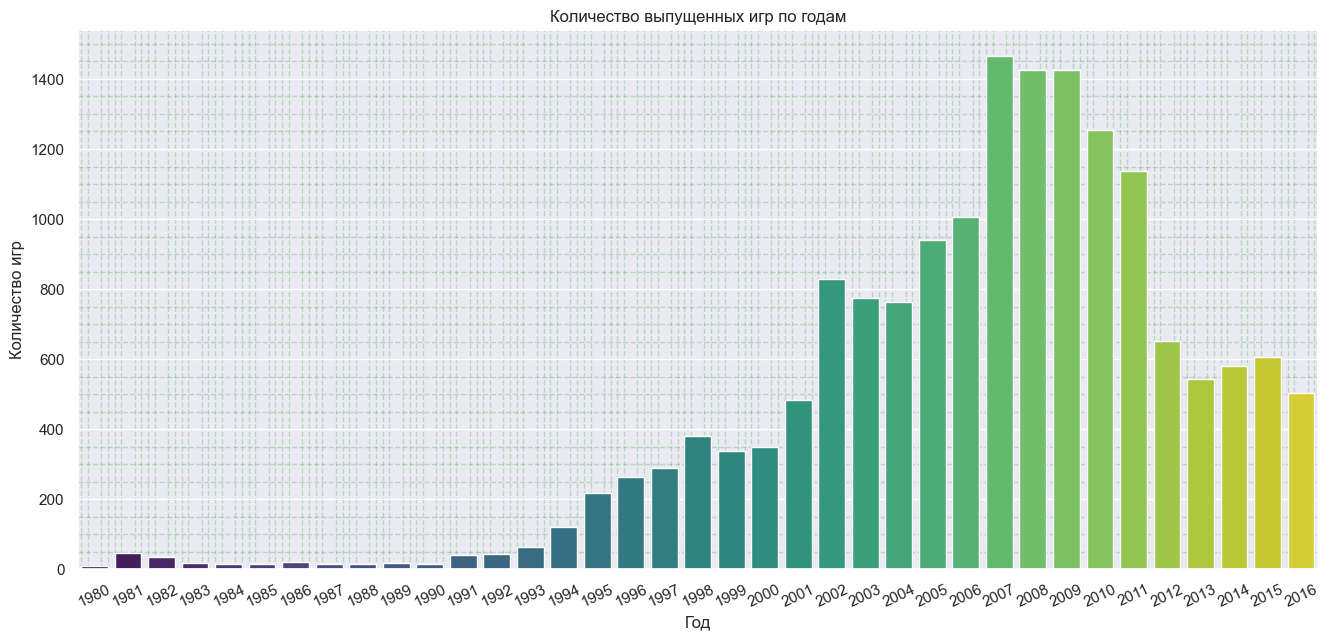

In [23]:
# Строим гистограмму для столбца 'year_of_release'
plt.figure(figsize=(16,7))
sns.countplot(x='year_of_release', data=games, palette='viridis')
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xticks(rotation = 25)
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр');

**Вывод:** данные важны не за все периоды, так как количество выпущенных игр до 1992 года было значительно мало. Будем проводить исследование, учитывая данные с 1992 года.

#### **Как менялись продажи по платформам**

Посмотрим, как менялись продажи по платформам.

In [24]:
# Выведем топ-5 платформ в порядке убывания продаж
top_platform = (games
                .groupby('platform')
                .agg({'total_sales':'sum'})
                .reset_index()
                .sort_values(by='total_sales',ascending=False)
                .head(5)
               )
top_platform

,platform,total_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12


Выберем платформы с наибольшими суммарными продажами.

In [25]:
top_sales_games = games.query('platform in @top_platform.platform')

Построим распределение по годам.

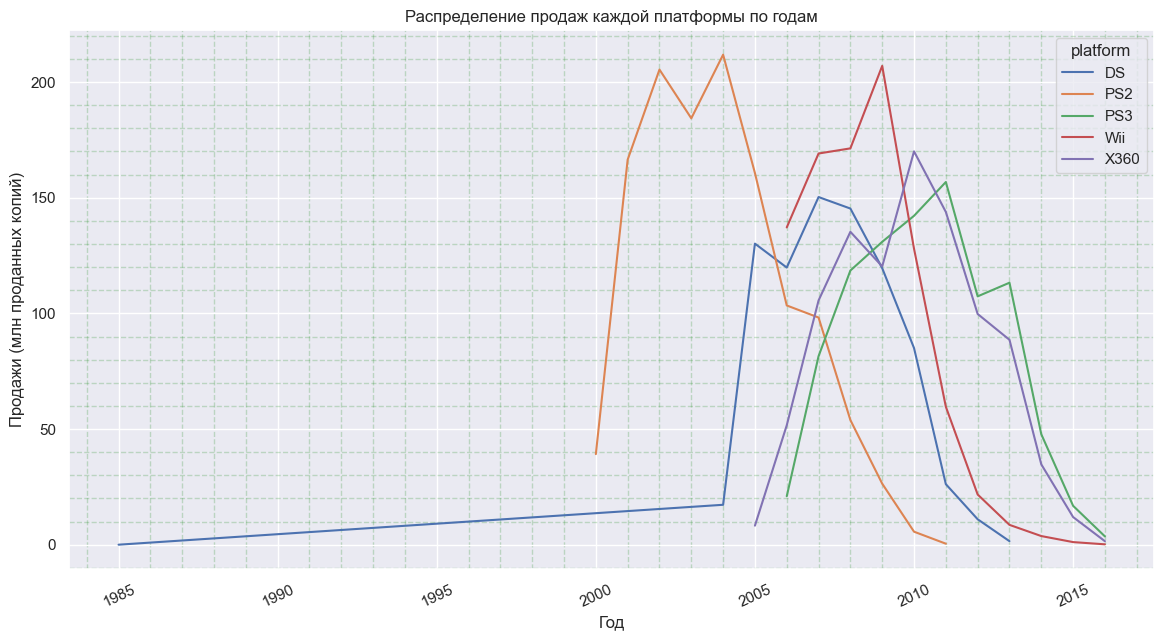

In [26]:
# Строим распределение продаж по годам для каждой из топ-5 платформ  
plt.figure(figsize=(14, 7))
sns.lineplot(data=top_sales_games
             .groupby(['platform','year_of_release'])
             .agg({'total_sales':'sum'}), 
             x="year_of_release", 
             y="total_sales", 
             hue="platform")
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xticks(rotation = 25)
plt.title('Распределение продаж каждой платформы по годам')
plt.xlabel('Год')
plt.ylabel('Продажи (млн проданных копий)');

**Вывод:** за характерный срок 9-10 лет появляются новые и исчезают старые платформы.

Возьмем данные за соответствующий актуальный период, который поможет построить прогноз на 2017 год. Предыдущие годы не будем учитывать. Соответственно, ограничим наш датасет и в дальнейшем будем исследовать данные с 2012 года.

In [27]:
games = games.drop(games[games['year_of_release'] < 2012].index)

#### **Какие платформы лидируют по продажам, растут или падают**

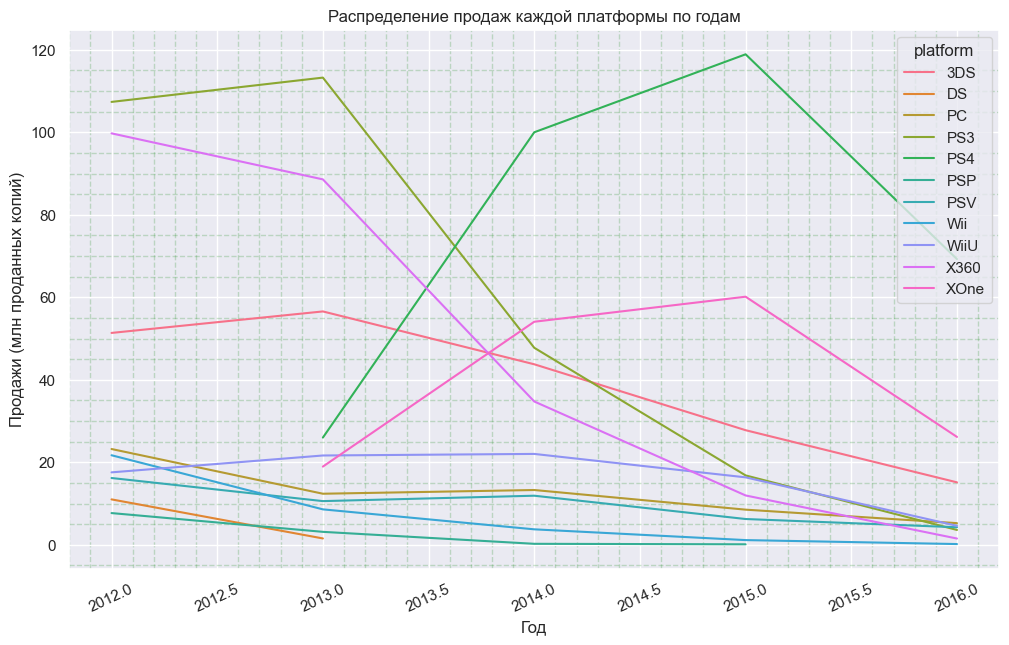

In [28]:
# Строим распределение продаж по годам для актуального периода с 2008 года
plt.figure(figsize=(12, 7))
sns.lineplot(data=games
             .groupby(['platform','year_of_release'])
             .agg({'total_sales':'sum'}), 
             x="year_of_release", 
             y="total_sales", 
             hue="platform")
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xticks(rotation = 25)
plt.title('Распределение продаж каждой платформы по годам')
plt.xlabel('Год')
plt.ylabel('Продажи (млн проданных копий)');

In [29]:
# Выведем топ-5 платформ по продажам за актуальный период
(games
                .groupby('platform')
                .agg({'total_sales':'sum'})
                .reset_index()
                .sort_values(by='total_sales',ascending=False)
                .head(5)
                )

,platform,total_sales
4,PS4,314.14
3,PS3,288.79
9,X360,236.54
0,3DS,194.61
10,XOne,159.32


**Вывод:** Падают продажи у платформ WiiU, PC. 

Продажи в сравнении с другими растут у платформ PS4, X360, 3DS, XOne, PS3. Выберем их как потенциально прибыльные платформы.

#### «Ящик с усами» по глобальным продажам игр в разбивке по платформам

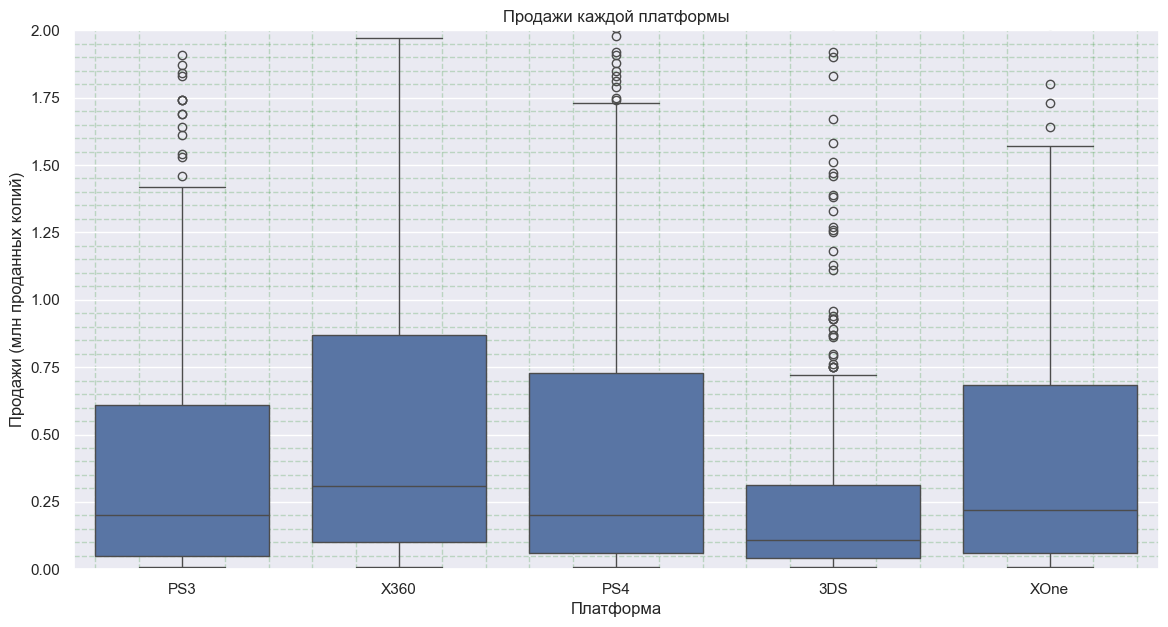

In [30]:
# Строим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 
plt.figure(figsize=(14, 7))
sns.boxplot(x='platform',
            y='total_sales', 
            data=games[games['platform'].isin(['PS4', 'X360', '3DS', 'XOne', 'PS3'])])
plt.ylim(0,2)
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.title('Продажи каждой платформы')
plt.ylabel('Продажи (млн проданных копий)')
plt.xlabel('Платформа');

In [31]:
games[games['platform'].isin(['PS4', 'X360', '3DS', 'XOne', 'PS3'])]['total_sales'].describe()

count    1820.000000
mean        0.655714
std         1.477562
min         0.010000
25%         0.060000
50%         0.190000
75%         0.630000
max        21.050000
Name: total_sales, dtype: float64

**Вывод:** выбросы в сторону максимума присутствуют в каждой из 5 платформ, самый большой выброс у `PS3`- 21 млн копий, самый большой межквартильный размах у `X360` - 0,75 млн копий.

#### **Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы**

Построим диаграммы рассеяния, посмотрим, как соотносятся продажи с отзывами критиков и пользователей у платформы PS4. 

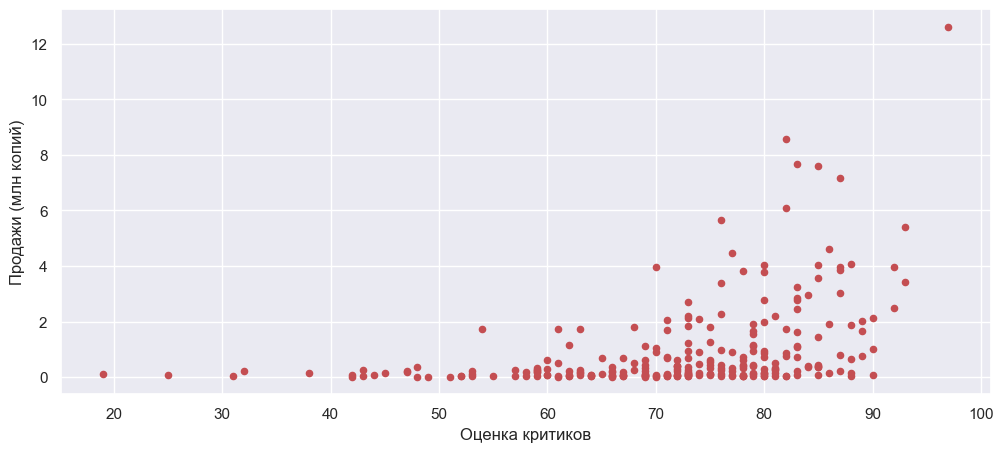

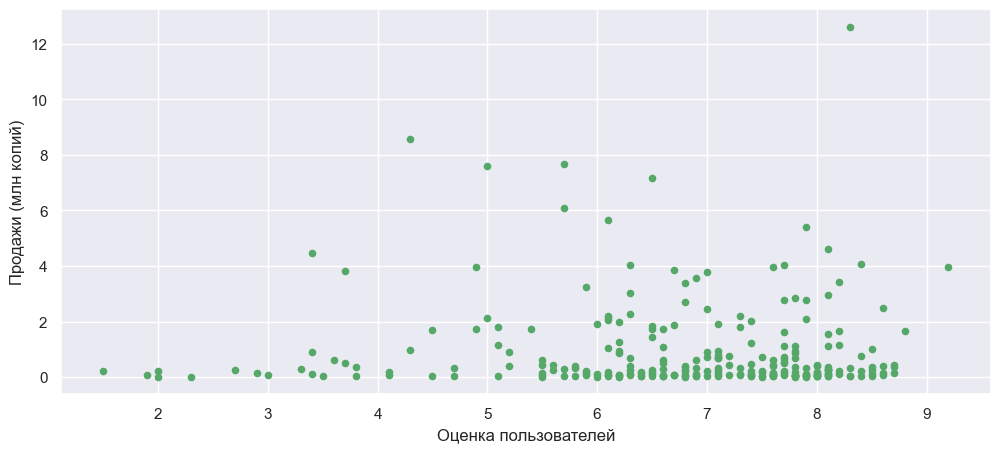

In [32]:
# Создаем отдельный датафрейм по платформе
ps4_games = games.query('platform == "PS4"')
# Строим диаграммы рассеяния
ps4_games.plot(x='critic_score',
               y='total_sales',
               kind='scatter',
               color='r',
               xlabel='Оценка критиков',
               ylabel='Продажи (млн копий)',
               figsize=(12,5))
ps4_games.plot(x='user_score',
               y='total_sales',
               kind='scatter',
               color='g',
               xlabel='Оценка пользователей',
               ylabel='Продажи (млн копий)',
               figsize=(12,5));

Посчитаем корреляцию между отзывами и продажами.

In [33]:
ps4_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 31 to 16585
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             392 non-null    object 
 1   platform         392 non-null    object 
 2   year_of_release  392 non-null    Int64  
 3   genre            392 non-null    object 
 4   na_sales         392 non-null    float64
 5   eu_sales         392 non-null    float64
 6   jp_sales         392 non-null    float64
 7   other_sales      392 non-null    float64
 8   critic_score     252 non-null    float64
 9   user_score       257 non-null    float64
 10  rating           392 non-null    object 
 11  total_sales      392 non-null    float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 40.2+ KB


In [38]:
numeric_cols = ['total_sales', 'critic_score', 'user_score']
correlation = ps4_games[numeric_cols].corr()
correlation['total_sales']

total_sales     1.000000
critic_score    0.406568
user_score     -0.031957
Name: total_sales, dtype: float64

**Вывод:** Корреляция между продажами и отзывами критиков слабая положительная, а между продажами и отзывами пользователей - очень слабая отрицательная. Значит отзывы критиков и пользователей не влияют на продажи внутри платформы PS4.

#### **Продажи игр на других платформах**

Соотнесем выводы с продажами игр на других платформах.

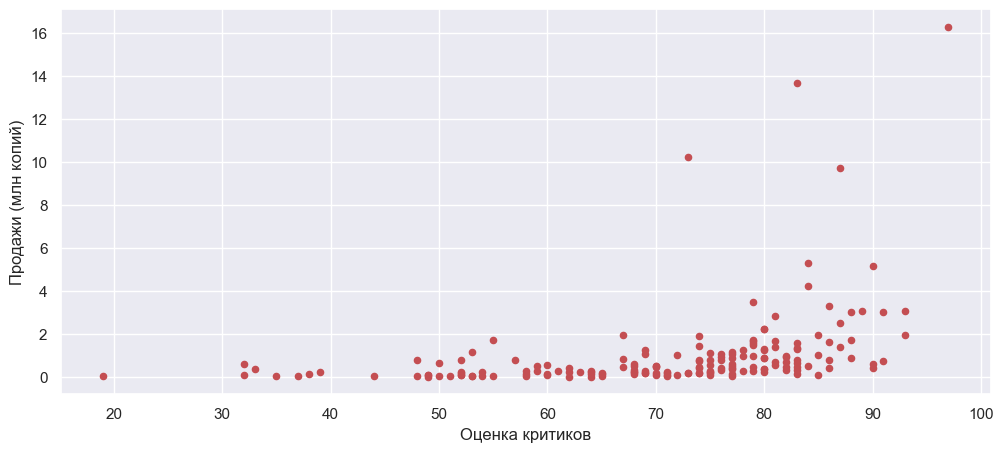

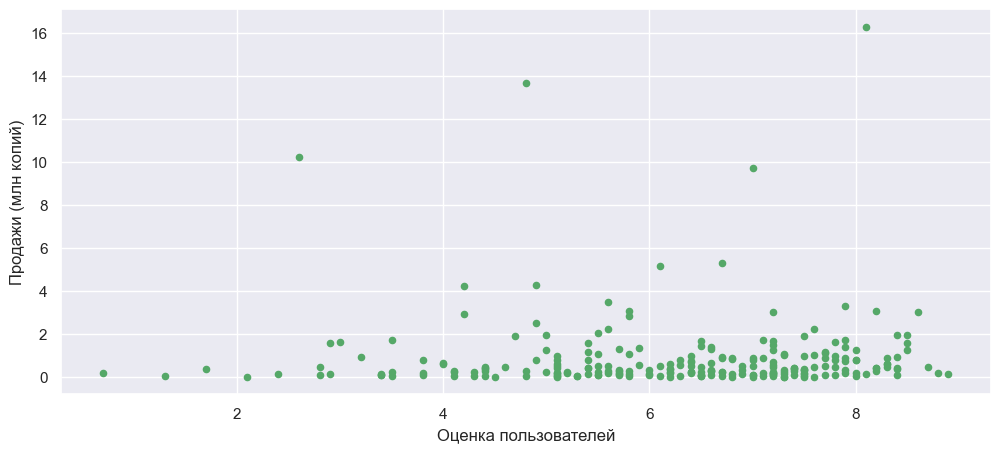

In [39]:
# Создаем отдельный датафрейм по платформе
x360_games = games.query('platform == "X360"')
# Строим диаграммы рассеяния по платформе X360
x360_games.plot(x='critic_score',
               y='total_sales',
               kind='scatter',
               color='r',
               xlabel='Оценка критиков',
               ylabel='Продажи (млн копий)',
               figsize=(12,5))
x360_games.plot(x='user_score',
               y='total_sales',
               kind='scatter',
               color='g',
               xlabel='Оценка пользователей',
               ylabel='Продажи (млн копий)',
               figsize=(12,5));

Посчитаем корреляцию между отзывами и продажами.

In [41]:
correlation = x360_games[numeric_cols].corr()
correlation['total_sales']

total_sales     1.000000
critic_score    0.360573
user_score      0.006164
Name: total_sales, dtype: float64

**Вывод:** Корреляция между продажами и отзывами критиков и пользователей очень слабая положительная. Значит отзывы критиков и пользователей не влияют на продажи внутри платформы X360.

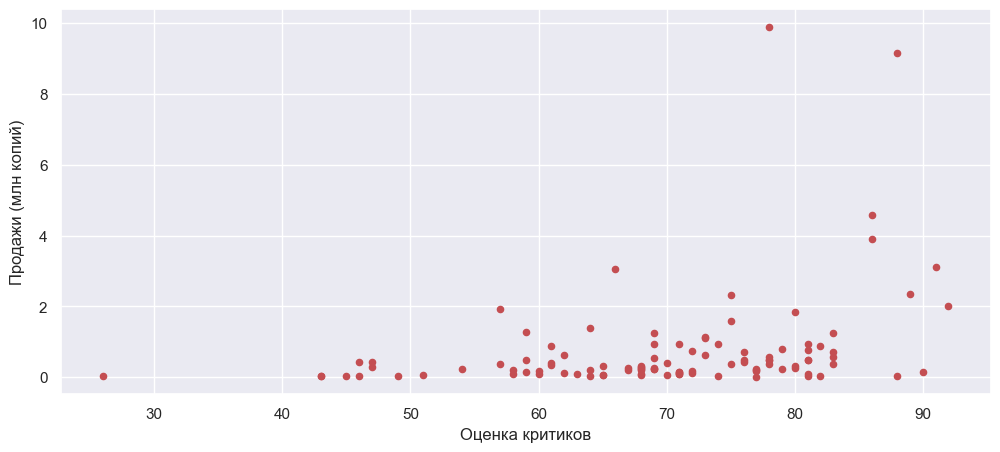

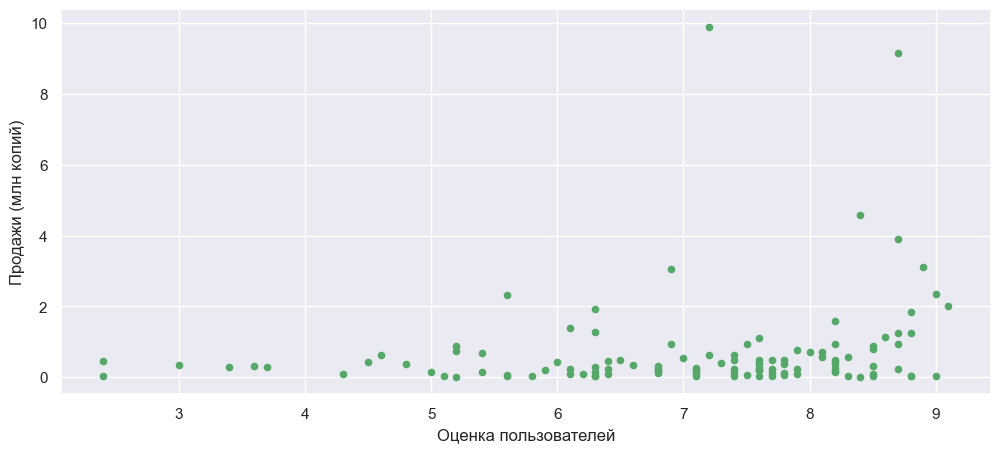

In [42]:
# Создаем отдельный датафрейм по платформе
ds_games = games.query('platform == "3DS"')
# Строим диаграммы рассеяния по платформе X360
ds_games.plot(x='critic_score',
               y='total_sales',
               kind='scatter',
               color='r',
               xlabel='Оценка критиков',
               ylabel='Продажи (млн копий)',
               figsize=(12,5))
ds_games.plot(x='user_score',
               y='total_sales',
               kind='scatter',
               color='g',
               xlabel='Оценка пользователей',
               ylabel='Продажи (млн копий)',
               figsize=(12,5));

Посчитаем корреляцию между отзывами и продажами.

In [43]:
correlation = ds_games[numeric_cols].corr()
correlation['total_sales']

total_sales     1.000000
critic_score    0.320803
user_score      0.197583
Name: total_sales, dtype: float64

**Вывод**: Корреляция между продажами и отзывами критиков и пользователей очень слабая положительная. Значит отзывы критиков и пользователей не влияют на продажи внутри платформы 3DS.

**Общий вывод:** корреляция между отзывами критиков и пользователей и продажами очень слабая положительная. В сравнении с показателями исследованных платформ, можно сделать следующий вывод:  отзывы критиков и пользователей не влияют на продажи платформы.

#### **Общее распределение игр по жанрам**

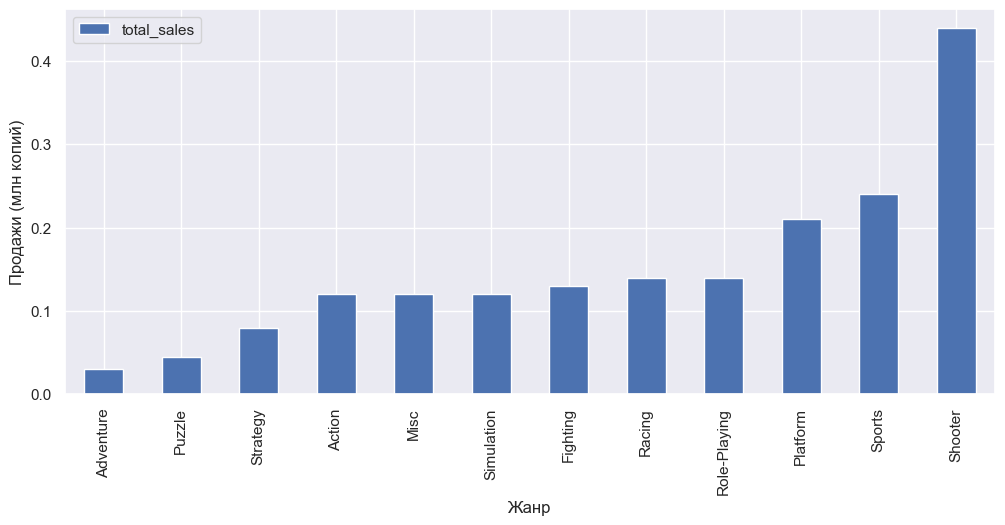

In [44]:
# Построим столбчатую диаграмму для столбца 'genre'
(games
    .groupby('genre')
    .agg({'total_sales':'median'})
    .sort_values(by='total_sales')
    .plot(kind='bar',
          xlabel='Жанр',
          ylabel='Продажи (млн копий)',
          figsize=(12,5))

);

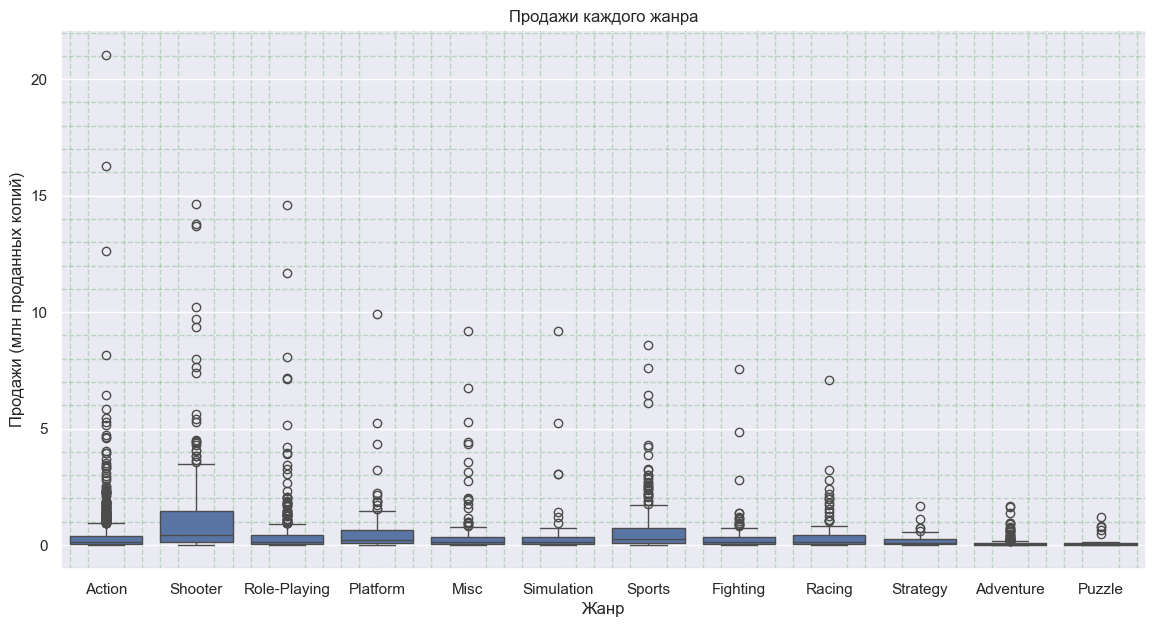

In [45]:
# Строим график «ящик с усами» по продажам игр в разбивке по жанрам. 
plt.figure(figsize=(14, 7))
sns.boxplot(x='genre',
            y='total_sales', 
            data=games.sort_values(by='total_sales', ascending=False))
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.title('Продажи каждого жанра')
plt.ylabel('Продажи (млн проданных копий)')
plt.xlabel('Жанр');

**Вывод:** самым прибыльным жанром является шутер и экшн, у шутера самый большой межквартильный размах ~ 1,5 млн, а у экшна самый высокий выброс ~ 21 млн. Также высокие продажи у платформенных, ролевых, спорта. Выделяются жанры с низкими продажами - пазл и приключения.

### **Портрет пользователя  каждого региона**
<a id='portrait'></a>

Определим для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5);

- Самые популярные жанры (топ-5);

- Влияет ли рейтинг ESRB на продажи в отдельном регионе.


In [46]:
# Создаем функцию для создания топ-5 параметров в разных регионах
def top_5_grouped(column,value):
    return (games
            .groupby(column)
            .agg({value:'mean'})
            .sort_values(by=value, ascending=False)
            .head(5)
           )

#### **Самые популярные платформы**

In [47]:
# Выведем топ-5 популярных платформ в Северной Америке
na_top_platform = top_5_grouped('platform', 'na_sales')
na_top_platform

,na_sales
platform,
X360,0.479623
XOne,0.377004
Wii,0.323148
PS4,0.277398
WiiU,0.259184


In [48]:
# Выведем топ-5 популярных платформ в Европе
eu_top_platform = top_5_grouped('platform', 'eu_sales')
eu_top_platform

,eu_sales
platform,
PS4,0.359923
X360,0.255205
Wii,0.220741
PS3,0.216755
XOne,0.208866


In [49]:
# Выведем топ-5 популярных платформ в Японии
jp_top_platform = top_5_grouped('platform', 'jp_sales')
jp_top_platform

,jp_sales
platform,
3DS,0.221692
DS,0.120000
WiiU,0.088503
PS3,0.071582
Wii,0.062778


In [50]:
# Посмотрим на общую таблицу из топовых платформ
na_top_platform.join([eu_top_platform, jp_top_platform], how='outer')

,na_sales,eu_sales,jp_sales
platform,,,
X360,0.479623,0.255205,NaN
XOne,0.377004,0.208866,NaN
Wii,0.323148,0.220741,0.062778
PS4,0.277398,0.359923,NaN
WiiU,0.259184,NaN,0.088503
PS3,NaN,0.216755,0.071582
3DS,NaN,NaN,0.221692
DS,NaN,NaN,0.120000


**Вывод:** Во всех 3 регионах популярна платформа Wii. В топ-5 у Европы и Америки входят одни и те же 4 платформы: Wii, X360, PS4, XOne. Среди японцев популярны 3DS и DS, однако в топ Европы и Америки эти платформы даже не вошли. Можно сказать, что топ-5 платформ Японии отличается от Америки и Европы.

#### **Самые популярные жанры**

In [51]:
# Выведем топ-5 популярных жанров в Северной Америке
na_top_genre = top_5_grouped('genre', 'na_sales')
na_top_genre

,na_sales
genre,
Shooter,0.616043
Sports,0.304216
Platform,0.298588
Misc,0.198906
Fighting,0.181560


In [52]:
# Выведем топ-5 популярных жанров в Европе
eu_top_genre = top_5_grouped('genre', 'eu_sales')
eu_top_genre

,eu_sales
genre,
Shooter,0.482851
Sports,0.257799
Platform,0.251882
Racing,0.237304
Simulation,0.181875


In [53]:
# Выведем топ-5 популярных жанров в Японии
jp_top_genre = top_5_grouped('genre', 'jp_sales')
jp_top_genre

,jp_sales
genre,
Role-Playing,0.176865
Simulation,0.130125
Platform,0.101529
Fighting,0.086606
Puzzle,0.076429


In [54]:
# Посмотрим на общую таблицу из топовых жанров
na_top_genre.join([eu_top_genre, jp_top_genre], how='outer')

,na_sales,eu_sales,jp_sales
genre,,,
Shooter,0.616043,0.482851,NaN
Sports,0.304216,0.257799,NaN
Platform,0.298588,0.251882,0.101529
Misc,0.198906,NaN,NaN
Fighting,0.181560,NaN,0.086606
Racing,NaN,0.237304,NaN
Simulation,NaN,0.181875,0.130125
Role-Playing,NaN,NaN,0.176865
Puzzle,NaN,NaN,0.076429


**Вывод:** Во всех 3 регионах популярен жанр платформенный. В топ-5 у Европы и Америки входят одни и те же 3 жанра: шутер, платформенный, спорт. Среди японцев популярны пазл, ролевые, однако в топ Европы и Америки эти платформы даже не вошли. Можно сказать, что топ-5 жанров Японии сильно отличается от Америки и Европы. Это может быть связано с менталитетом того или иного региона.

#### **Влияет ли рейтинг ESRB на продажи в отдельном регионе**

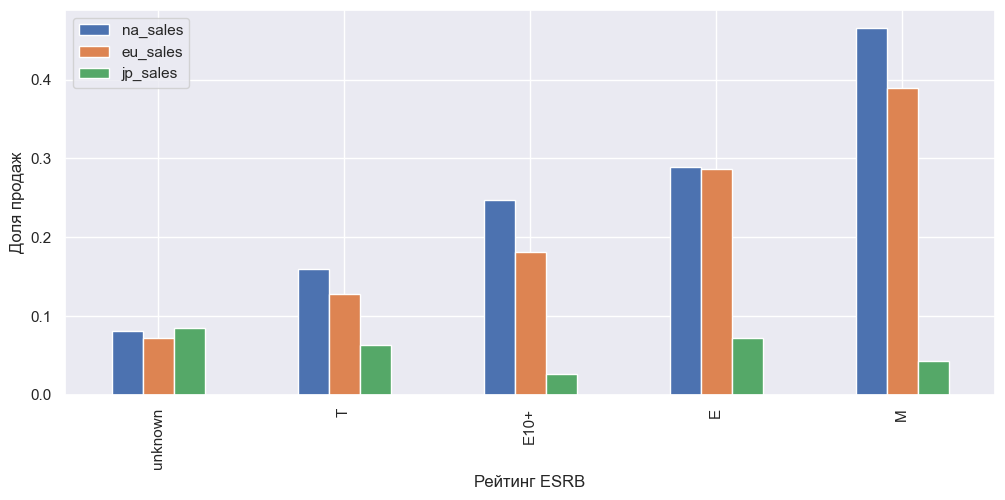

In [55]:
# Строим столбчатую диаграмму рейтинга для регионов
(games
    .groupby('rating')
    .agg({'na_sales':'mean','eu_sales':'mean','jp_sales':'mean'})
    .sort_values(by='na_sales')
    .plot(kind='bar',
          xlabel='Рейтинг ESRB',
          ylabel='Доля продаж',
          figsize=(12,5))
);

**Вывод:** рейтинг влияет на продажи в Северной Америке и Европе, а в Японии продажи не зависят от рейтинга ESRB.

### **Проверка гипотез**
<a id='hypothesis'></a>

#### **Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

H<sub>0</sub>: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H<sub>1</sub>: Средние пользовательские рейтинги платформ Xbox One и PC разные

Мы имеем дело с независимыми выборками, будем проверять двустороннюю гипотезу о равенстве средних двух генеральных совокупностей. 

In [56]:
# Удалим пропущенные значения в выборке
x_one = games[games['platform']=='XOne'].dropna()
pc = games[games['platform']=='PC'].dropna()
# задаём уровень значимости
alpha = 0.05
# Сравним дисперсии выборок с помощью стат теста Левене
stat, p = st.levene(x_one['user_score'], pc['user_score'])
if p > alpha:
    print('Дисперси выборок равны')
else:
    print('Дисперсии не равны')

Дисперсии не равны


Тест Левене показал, что дисперсии выборок не равны, значит в т-тесте аргумент equal_var заменим на False

In [57]:
# проводим ttest для двух выборок, в качестве альтернативной используем двустороннюю гипотезу
results = st.ttest_ind(x_one['user_score'], pc['user_score'], equal_var=False)
print(f'p-значение:{results.pvalue:.4f}')
# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC разные')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение:0.5927
Нет оснований отвергнуть нулевую гипотезу


**Вывод:** средний пользовательские рейтинги платформ Xbox One и PC  одинаковые.

#### Средние пользовательские рейтинги жанров Action и Sports разные
H<sub>0</sub>: Средние пользовательские рейтинги жанров Action и Sports одинаковые

H<sub>1</sub>: Средние пользовательские рейтинги жанров Action и Sports разные

Мы имеем дело с независимыми выборками, будем проверять двустороннюю гипотезу о равенстве средних двух генеральных совокупностей.

In [58]:
# Удалим пропущенные значения в выборке
action = games[games['genre']=='Action'].dropna()
sports = games[games['genre']=='Sports'].dropna()
# задаём уровень значимости
alpha = 0.05
# Сравним дисперсии выборок с помощью стат теста Левене
stat, p = st.levene(action['user_score'], sports['user_score'])
if p > alpha:
    print('Дисперси выборок равны')

Дисперси выборок равны


Тест Левене показал, что дисперсии выборок равны, значит в т-тесте оставляем аргумент equal_var по умолчанию

In [59]:
# проводим ttest для двух выборок, в качестве альтернативной используем двустороннюю гипотезу
results = st.ttest_ind(action['user_score'], sports['user_score'])
print(f'p-значение:{results.pvalue:.4f}')
# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports разные')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение:0.0000
Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports разные


**Вывод:** Средние пользовательские рейтинги жанров Action и Sports разные.

### Выводы
<a id='final'></a>

Таким образом мы провели исследование данных покупателей интернет-магазина «Стримчик» и выполнили следующие цели:
1. Выявили актуальный период, который помог построить прогноз на 2017 год.
2. Рассмотрели продажи игр в зависимости от платформы, отзывов, жанров.
3. Составили портрет пользователя каждого региона.
4. Проверили гипотезы о средних пользовательский рейтингах в разных категориях.

Для этого были выполнены следующие действия:

- **Открыт файл** с данными и изучена общая информация: в датафрейме **16715 строк и 11 столбцов**, имелись пропуски, неправильные типы данных и названия столбцов.


- Выполнена **предобработка данных:**
    
    переименовали названия столбцов в нижний регистр;
    
    привели тип данных на целочисленный в столбцах 'year_of_release', 'critic_score', потому что у них была нулевая дробная часть. А также изменили данные в 'user_score', которые хранились в виде строк, хотя представляют числовую характеристику;
    
    заполнили пропущенные значения там, где возможно;
    
    создали новый столбец с продажами во всех регионах, который помог в дальнейших исследованиях;
    
    изучили неявные и явные дубликаты, которых не было обнаружено.


- Провели **исследовательский анализ данных:**

  рассмотрели, сколько игр выпускалось в разные годы и выяснили, что данные важны не за все периоды, так как количество выпущенных игр до 1992 года было значительно мало. Таким образом, мы проводили исследование, учитывая данные с 1992 года;

  определили, как менялись продажи по платформам: за характерный срок 9-10 лет появляются новые и исчезают старые платформы. Взяли данные за актуальный период - 5 лет, который помог построить прогноз на 2017 год. Предыдущие годы не учитывали. Соответственно, ограничили наш датасет 2012 годом;

  изучили, какие платформы лидируют по продажам, растут или падают: Падают продажи у платформ WiiU, PC. Продажи в сравнении с другими растут у платформ PS4, X360, 3DS, XOne, PS3.Выбрали их как потенциально **прибыльные платформы**;

  выяснили, что выбросы в сторону максимума присутствуют в каждой из 5 платформ, самый большой выброс у PS3- 21 млн копий, самый большой межквартильный размах у X360 - 1 млн копий;
  
  сделали вывод о том, что отзывы критиков и пользователей не влияют на продажи платформы;
  
  узнали, самым прибыльным жанром является шутер и экшн, у шутера самый большой межквартильный размах ~ 1,5 млн, а у экшна самый высокий выброс ~ 21 млн. Также высокие продажи у платформенных, ролевых, спорта. Выделяются жанры с низкими продажами - пазл и приключения.
  

- **Составили портрет жителя каждого региона**: топ-5 платформ и жанров Японии сильно отличается от Америки и Европы. Это может быть связано с менталитетом того или иного региона. Рейтинг ESRB влияет на продажи в Северной Америке и Европе, а в Японии продажи не зависят от рейтинга.


- **Проверили гипотезы** и выяснили, что:

  средний пользовательские рейтинги платформ Xbox One и PC одинаковые;

  средние пользовательские рейтинги жанров Action и Sports разные.

**Рекомендации для бизнеса:** сделать ставку на потенциально прибыльные платформы: X360, PS4, X360, 3DS, XOne, также обратить внимание на жанры шутер и экшн. Во время рекламной кампании иметь в виду сильное влияние рейтинга ESRB в Северной Америке и Европе.
  